# Fine-Tune FLAN-T5 with Reinforcement Learning (PPO) and PEFT to Generate Less-Toxic Summaries

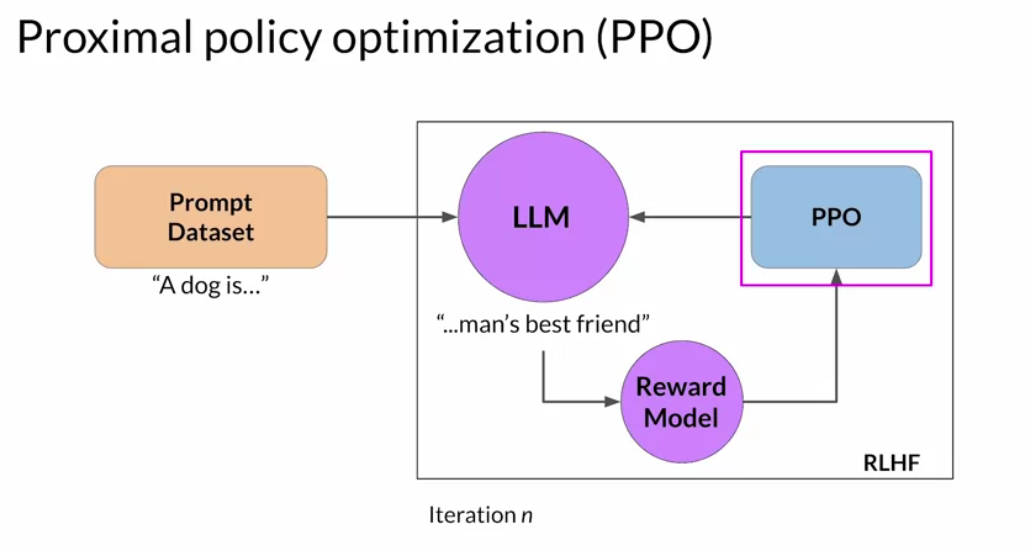

This is a practice notebook by Mark Redito to learn and practice Reinforcement Learning and PEFT to Generate Less-Toxic Summaries. This notebook is taken from the course [Generative AI with LLMs](https://www.deeplearning.ai/courses/generative-ai-with-llms/)  by DeepLearning.AI, AWS and Coursera with additional comments from Redito. Please note that this notebook is intended for folks new to AI/ML who want to understand what's going on under the hood therefore all the notes are verbose and thorough.

In this notebook, you will fine-tune a FLAN-T5 model to generate less toxic content with Meta AI's hate speech reward model. The reward model is a binary classifier that predicts either "not hate" or "hate" for the given text. You will use Proximal Policy Optimization (PPO) to fine-tune and reduce the model's toxicity.

# Install Dependencies

In [ ]:
%pip install --upgrade pip #  Upgrades the Python Package Installer (pip) to its latest version.
%pip install --disable-pip-version-check \
    torch==1.13.1 \ #pytorch
    torchdata==0.5.1 --quiet

%pip install \
    transformers==4.27.2 \ #transformer from the previous notebook
    datasets==2.11.0 \ #to access our datasets
    evaluate==0.4.0 \ #to do our evals
    rouge_score==0.1.2 \ # for evals
    peft==0.3.0 --quiet #parameter efficient fine tuning

# Installing the Reinforcement Learning library directly from github.
%pip install git+https://github.com/lvwerra/trl.git@25fa1bd

###Package installations: spelled out

Here's a breakdown of the packages being installed and their likely purposes in the context of this notebook:

1. **`torch==1.13.1`**: This is PyTorch, a deep learning framework. It's often used for various machine learning tasks, including natural language processing (NLP). It's likely the primary library used for model handling in this notebook.

2. **`torchdata==0.5.1`**: This package could be used for more advanced data loading functionalities in PyTorch. It's likely used to handle the dataset efficiently.

3. **`transformers==4.27.2`**: This is a library from Hugging Face that provides pre-trained models and training utilities for various NLP tasks. Given that the notebook is about fine-tuning a text generation model, this package is essential.

4. **`datasets==2.11.0`**: Also from Hugging Face, this library provides easy-to-use datasets and data loading utilities. It's likely used for gathering the data needed for training and evaluation.

5. **`evaluate==0.4.0`**: This package is likely used for evaluating the model.

6. **`rouge_score==0.1.2`**: ROUGE (Recall-Oriented Understudy for Gisting Evaluation) is a set of metrics used to evaluate the quality of summaries by comparing them to reference summaries. This package likely provides these metrics.

7. **`peft==0.3.0`**: This package isn't well-known, but based on the name, it could be used for performance evaluation or testing.

### `trl` Library

The `trl` library is installed directly from a GitHub repository. It stands for "Transformers Reinforcement Learning" and is likely used to facilitate the application of reinforcement learning algorithms to transformer models. The notebook's objective of fine-tuning a model to generate less toxic content is a typical use case for reinforcement learning. The library likely provides utilities to make this process easier, such as implementing Proximal Policy Optimization (PPO), which is mentioned in the notebook's introduction.

Import other necessary components:

In [ ]:
#AutoModelForSequenceClassification is what were going to use to load Meta's binary classifier
from transformers import pipeline, AutoTokenizer, AutoModelForSequenceClassification, AutoModelForSeq2SeqLM, GenerationConfig
from datasets import load_dataset # our dataset
from peft import PeftModel, PeftConfig, LoraConfig, TaskType #PEFT and LoRA configs

# trl: Transformer Reinforcement Learning library
from trl import PPOTrainer, PPOConfig, AutoModelForSeq2SeqLMWithValueHead #our PPO trainer
from trl import create_reference_model
from trl.core import LengthSampler #allows us to sample text in various lengths

import torch
import evaluate

import numpy as np
import pandas as pd

# tqdm library makes the loops show a smart progress meter.
from tqdm import tqdm
tqdm.pandas()

###**Imported components: spelled out.**

The eleventh cell is a code cell that imports various Python packages and modules. Here's the breakdown:

### Transformers and Datasets
1. **`from transformers import ...`**: Imports various components from Hugging Face's `transformers` library. These include utilities for sequence classification, sequence-to-sequence language models, and model configurations.
    - `pipeline`: Simplifies the process of applying transformers to various tasks.
    - `AutoTokenizer`: General class for auto-discovering and loading the appropriate tokenizer for a given pre-trained model.
    - `AutoModelForSequenceClassification`: For sequence classification tasks like sentiment analysis.
    - `AutoModelForSeq2SeqLM`: For sequence-to-sequence tasks like translation or summarization.
    - `GenerationConfig`: Likely for configuring generation settings.

2. **`from datasets import load_dataset`**: Imports the `load_dataset` function from Hugging Face's `datasets` library, used for loading datasets easily.

### Peft
3. **`from peft import ...`**: Imports various components from the `peft` library. While the library isn't well-known, based on the names, it likely deals with performance evaluation or task configurations.

### TRL (Transformers Reinforcement Learning)
4. **`from trl import ...`**: Imports several components from the `trl` library, including:
    - `PPOTrainer`: For Proximal Policy Optimization training.
    - `PPOConfig`: Configuration settings for PPO.
    - `AutoModelForSeq2SeqLMWithValueHead`: A specialized Seq2Seq model with an additional value head for reinforcement learning.
    - `create_reference_model`: Function to create a reference model.
    - `LengthSampler`: Likely for sampling sequences of varying lengths.

### Others
5. **`import torch`**: Imports PyTorch, the deep learning framework.
6. **`import evaluate`**: Imports the `evaluate` library, likely for model evaluation.
7. **`import numpy as np` and `import pandas as pd`**: Imports NumPy and Pandas for numerical and data manipulation.
8. **`from tqdm import tqdm`**: Imports `tqdm` for displaying progress bars.
9. **`tqdm.pandas()`**: This line activates the progress bar functionality for Pandas operations.

# Load FLAN-T5 Model, Prepare Reward Model and Toxicity Evaluator

### Load Data and FLAN-T5 model Fine-tuned with Summarization Instruction

You will keep working with the same Hugging Face dataset [DialogSum](https://huggingface.co/datasets/knkarthick/dialogsum) and the pre-trained model [FLAN-T5](https://huggingface.co/docs/transformers/model_doc/flan-t5).

In [ ]:
model_name="google/flan-t5-base" # the FLAN-T5 model
huggingface_dataset_name = "knkarthick/dialogsum" # the dataset

dataset_original = load_dataset(huggingface_dataset_name)

dataset_original


**Spelled out:**
1. **`model_name="google/flan-t5-base"`**: Sets the variable `model_name` to the string "google/flan-t5-base", which is likely the identifier for the FLAN-T5 model on Hugging Face's model hub.

2. **`huggingface_dataset_name = "knkarthick/dialogsum"`**: Sets the variable `huggingface_dataset_name` to the string "knkarthick/dialogsum", which is the identifier for the DialogSum dataset on Hugging Face's dataset hub.

3. **`dataset_original = load_dataset(huggingface_dataset_name)`**: Uses the `load_dataset` function from the `datasets` library to load the DialogSum dataset into the variable `dataset_original`.

4. **`dataset_original`**: This line is probably intended to display the basic structure or initial rows of the loaded dataset for quick inspection.

Here, we have our training dataset, our test dataset and our validation dataset.

The next step will be to preprocess the dataset. You will take only a part of it, then filter the dialogues of a particular length (just to make those examples long enough and, at the same time, easy to read). Then wrap each dialogue with the instruction and tokenize the prompts. Save the token ids in the field `input_ids` and decoded version of the prompts in the field `query`.

You could do that all step by step in the cell below, but it is a good habit to organize that all in a function `build_dataset`:

In [ ]:
def build_dataset(model_name,
                  dataset_name,
                  input_min_text_length,
                  input_max_text_length):

    """
    Preprocess the dataset and split it into train and test parts.

    Parameters:
    - model_name (str): Tokenizer model name.
    - dataset_name (str): Name of the dataset to load.
    - input_min_text_length (int): Minimum length of the dialogues.
    - input_max_text_length (int): Maximum length of the dialogues.

    Returns:
    - dataset_splits (datasets.dataset_dict.DatasetDict): Preprocessed dataset containing train and test parts.
    """

    # load dataset (only "train" part will be enough for this lab).
    dataset = load_dataset(dataset_name, split="train")

    # Filter the dialogues of length between input_min_text_length and input_max_text_length characters.
    dataset = dataset.filter(lambda x: len(x["dialogue"]) > input_min_text_length and len(x["dialogue"]) <= input_max_text_length, batched=False)

    # Prepare tokenizer. Setting device_map="auto" allows to switch between GPU and CPU automatically.
    tokenizer = AutoTokenizer.from_pretrained(model_name, device_map="auto")

    def tokenize(sample):

        # Wrap each dialogue with the instruction.
        prompt = f"""
Summarize the following conversation.

{sample["dialogue"]}

Summary:
"""
        sample["input_ids"] = tokenizer.encode(prompt)

        # This must be called "query", which is a requirement of our PPO library.
        sample["query"] = tokenizer.decode(sample["input_ids"])
        return sample

    # Tokenize each dialogue.
    dataset = dataset.map(tokenize, batched=False)
    dataset.set_format(type="torch")

    # Split the dataset into train and test parts.
    dataset_splits = dataset.train_test_split(test_size=0.2, shuffle=False, seed=42)

    return dataset_splits

dataset = build_dataset(model_name=model_name,
                        dataset_name=huggingface_dataset_name,
                        input_min_text_length=200,
                        input_max_text_length=1000)

print(dataset)

**Spelled out**

### Function Definition: `build_dataset`
- **Parameters**:
  - `model_name`: Tokenizer model name (string).
  - `dataset_name`: Name of the dataset to load (string).
  - `input_min_text_length`: Minimum length of the dialogues (integer).
  - `input_max_text_length`: Maximum length of the dialogues (integer).
  
- **Return Value**:
  - `dataset_splits`: A dictionary containing the preprocessed train and test datasets.
  
- **Inside the Function**:
  1. **Loading the Dataset**: Uses the `load_dataset` function to load the "train" split of the dataset.
  2. **Filtering Dialogues**: Filters dialogues based on their length using the `filter` method.
  3. **Tokenization Setup**: Initializes the tokenizer using `AutoTokenizer.from_pretrained`.
  4. **Dialogue Tokenization**: Wraps each dialogue with a summarization instruction and tokenizes it.
  5. **Formatting and Splitting**: Sets the dataset format to PyTorch and splits it into train and test datasets using `train_test_split`.

### Using the Function
After defining the function, the code calls `build_dataset` to preprocess the dataset with specified minimum and maximum text lengths (200 and 1000, respectively). It then prints the resulting `dataset` object.

- **`print(dataset)`**: This line is likely intended to display some basic information about the processed dataset.


In the previous notebook, we fine-tuned the PEFT model with summarization instructions. The training in the notebook was done on a subset of data. Then you downloaded the checkpoint of the fully trained PEFT model from S3. This is the model we trained in the [previous notebook](https://colab.research.google.com/drive/1wUvVU5_txqOaQ0fUaW4rlxaB5AM9WgKP?usp=sharing).

Let's load the same model checkpoint here:

In [ ]:
!aws s3 cp --recursive s3://dlai-generative-ai/models/peft-dialogue-summary-checkpoint/ ./peft-dialogue-summary-checkpoint-from-s3/

List the model item and check its size (it's less than 15 Mb):

In [ ]:
!ls -alh ./peft-dialogue-summary-checkpoint-from-s3/adapter_model.bin

Prepare a function to pull out the number of model parameters (it is the same as in the previous lab):

In [ ]:
def print_number_of_trainable_model_parameters(model):
    trainable_model_params = 0
    all_model_params = 0
    for _, param in model.named_parameters():
        all_model_params += param.numel()
        if param.requires_grad:
            trainable_model_params += param.numel()
    return f"\ntrainable model parameters: {trainable_model_params}\nall model parameters: {all_model_params}\npercentage of trainable model parameters: {100 * trainable_model_params / all_model_params:.2f}%"

**Spelled out**
The twenty-third cell is a code cell that defines a function called `print_number_of_trainable_model_parameters`. This function calculates and returns various statistics related to the number of parameters in a given model.

Here's the breakdown of the function:

### Function Definition: `print_number_of_trainable_model_parameters`
- **Parameters**:
  - `model`: A PyTorch model whose parameters you want to analyze.
  
- **Return Value**:
  - A formatted string that displays the number of trainable parameters, the total number of parameters, and the percentage of trainable parameters.

### Inside the Function:
1. **Initialize Counters**: Two variables (`trainable_model_params` and `all_model_params`) are initialized to zero. They will store the counts of trainable and total parameters, respectively.
  
2. **Loop Through Parameters**: The function loops through each parameter tensor in the model using `model.named_parameters()`.
  
3. **Count All Parameters**: For each parameter tensor, its total number of elements (`param.numel()`) is added to `all_model_params`.

4. **Count Trainable Parameters**: If the parameter tensor requires gradients (`param.requires_grad` is True), its total number of elements is added to `trainable_model_params`.

5. **Calculate and Return Statistics**: The function calculates the percentage of trainable parameters and returns a formatted string with all the calculated statistics.

This function will be useful for understanding the complexity of the model in terms of its parameter count.

Add the adapter to the original FLAN-T5 model. In the previous lab you were adding the fully trained adapter only for inferences, so there was no need to pass LoRA configurations doing that. Now you need to pass them to the constructed PEFT model, also putting `is_trainable=True`.

In [ ]:
lora_config = LoraConfig(
    r=32, # Rank
    lora_alpha=32,
    target_modules=["q", "v"],
    lora_dropout=0.05,
    bias="none",
    task_type=TaskType.SEQ_2_SEQ_LM # FLAN-T5
)

model = AutoModelForSeq2SeqLM.from_pretrained(model_name,
                                              torch_dtype=torch.bfloat16)

peft_model = PeftModel.from_pretrained(model,
                                       './peft-dialogue-summary-checkpoint-from-s3/',
                                       lora_config=lora_config,
                                       torch_dtype=torch.bfloat16,
                                       device_map="auto",
                                       is_trainable=True)

print(f'PEFT model parameters to be updated:\n{print_number_of_trainable_model_parameters(peft_model)}\n')

**Spelled out**
### Low Rank Adaptation (LoRA) Configuration
The cell starts by configuring LoRA using a `LoraConfig` object. This object likely contains settings for how the low-rank adaptation will be applied to the model.

- `r=32`: Specifies the rank for the low-rank approximation. Lower ranks result in fewer parameters.
- `lora_alpha=32`: Could be an additional scaling factor or regularization term for LoRA.
- `target_modules=["q", "v"]`: Indicates the modules to which LoRA will be applied. In the context of transformers, "q" and "v" usually refer to query and value in the attention mechanism.
- `lora_dropout=0.05`: Specifies the dropout rate to use during training.
- `bias="none"`: Indicates that no bias term is used.
- `task_type=TaskType.SEQ_2_SEQ_LM`: Specifies that the task is sequence-to-sequence language modeling, which is aligned with what FLAN-T5 is designed for.

### Load Pre-trained FLAN-T5 Model
The cell then loads a pre-trained FLAN-T5 model using the `AutoModelForSeq2SeqLM.from_pretrained` method, storing it in a variable named `model`.

- `torch_dtype=torch.bfloat16`: Specifies the data type for the model's tensors, likely to save memory and speed up computation.

### Initialize PEFT Model with LoRA
The cell initializes a PEFT model using `PeftModel.from_pretrained`. It takes the loaded FLAN-T5 model and adds an adapter with LoRA configurations.

- `lora_config=lora_config`: Passes the earlier-defined LoRA configuration.
- `torch_dtype=torch.bfloat16`: Specifies the data type for the model's tensors.
- `device_map="auto"`: Enables automatic device selection between CPU and GPU.
- `is_trainable=True`: Indicates that this model is intended to be fine-tuned further.

### Print Model Parameters
Finally, the `print_number_of_trainable_model_parameters` function is called to display the number of trainable parameters in the PEFT model. This provides insight into the model's complexity and how many parameters will be updated during training.

Above you see the trainable model parameters, all model parameters and the percentage of trainable paramters. Since we're using PEFT we're only training a few parameters.

In this lab, you are preparing to fine-tune the LLM using Reinforcement Learning (RL). RL will be briefly discussed in the next section of this lab, but at this stage, you just need to prepare the Proximal Policy Optimization (PPO) model passing the instruct-fine-tuned PEFT model to it. PPO will be used to optimize the RL policy against the reward model.

In [ ]:
# were putting the model in fine-tuning mode
ppo_model = AutoModelForSeq2SeqLMWithValueHead.from_pretrained(peft_model,
                                                               torch_dtype=torch.bfloat16,
                                                               is_trainable=True)

print(f'PPO model parameters to be updated (ValueHead + 769 params):\n{print_number_of_trainable_model_parameters(ppo_model)}\n')
print(ppo_model.v_head)

**Spelled Out**
### Initialize PPO Model with Value Head
The cell uses the function `AutoModelForSeq2SeqLMWithValueHead.from_pretrained` to initialize a Proximal Policy Optimization (PPO) model with a Value Head.

- **`peft_model`**: This is likely the PEFT model that was previously initialized. It serves as the base for the new PPO model.
- **`torch_dtype=torch.bfloat16`**: Specifies the data type for the model's tensors, probably to save memory and speed up computations.
- **`is_trainable=True`**: Sets the PPO model to be trainable.

The Value Head is typically used in Reinforcement Learning to estimate the expected return (or "value") of each state, helping the model to make better decisions.

### Print Model Parameters and Value Head
The cell then prints the number of parameters that will be updated during training. This is done using the `print_number_of_trainable_model_parameters` function defined earlier.

- **`print(ppo_model.v_head)`**: Prints the architecture or configuration of the Value Head in the PPO model.

This cell sets the stage for fine-tuning the language model using PPO, showing the user what parts of the model will be updated and providing details about the Value Head.

Output above: notice that the trainable model parameters went up a little higher. This is due to the additional `768` params from the `ValueHead` + 1 for bias.

During PPO, only a few parameters will be updated. Specifically, the parameters of the `ValueHead`. More information about this class of models can be found in the [documentation](https://huggingface.co/docs/trl/main/en/models#trl.create_reference_model). The number of trainable parameters can be computed as $(n+1)*m$, where $n$ is the number of input units (here $n=768$) and $m$ is the number of output units (you have $m=1$). The $+1$ term in the equation takes into account the bias term.

Now create a frozen copy of the PPO which will not be fine-tuned - a reference model. The reference model will represent the LLM before detoxification. None of the parameters of the reference model will be updated during PPO training. This is on purpose.

In [ ]:
ref_model = create_reference_model(ppo_model)

print(f'Reference model parameters to be updated:\n{print_number_of_trainable_model_parameters(ref_model)}\n')

**Spelled Out**
### Create Reference Model
It uses a function called `create_reference_model` to create a reference model based on the previously initialized PPO model.

- **`ref_model = create_reference_model(ppo_model)`**: This line likely creates a clone of the `ppo_model` but sets it to be non-trainable. The new model is stored in a variable called `ref_model`.

### Print Number of Trainable Parameters in Reference Model
Then it prints the number of trainable parameters in this reference model using the `print_number_of_trainable_model_parameters` function defined earlier.

- **`print(f'Reference model parameters to be updated:\\n{print_number_of_trainable_model_parameters(ref_model)}\\n')`**: This line prints out information about which, if any, parameters in the reference model will be updated during training. Given the context, we expect this number to be zero, as the reference model is supposed to be "frozen" or non-trainable.

The purpose of creating this reference model is likely to have a baseline model to compare against during or after the PPO training, especially for detoxification.

Note on above: in RLHF we use two models, one is a reference model (`ref_model`) which is not going to be trained and another one which will be trained. Then we use KL divergence to compare the outputs of the trained PPO model to the reference model to see how far the trained model is to the reference. This also minimizes "reward hacking".
When you run the cell, you might also notice that the trainable parameters are 0.

Now its time to train!

### Prepare Reward Model

**Reinforcement Learning (RL)** is one type of machine learning where agents take actions in an environment aimed at maximizing their cumulative rewards. The agent's behavior is defined by the **policy**. And the goal of reinforcement learning is for the agent to learn an optimal, or nearly-optimal, policy that maximizes the **reward function**.

In the [previous section](#2.1) the original policy is based on the instruct PEFT model - this is the LLM before detoxification. Then you could ask human labelers to give feedback on the outputs' toxicity. However, it can be expensive to use them for the entire fine-tuning process. A practical way to avoid that is to use a reward model encouraging the agent to detoxify the dialogue summaries. The intuitive approach would be to do some form of sentiment analysis across two classes (`nothate` and `hate`) and give a higher reward if there is higher a chance of getting class `nothate` as an output.

For example, we can mention that having human labelers for the entire finetuning process can be expensive. A practical way to avoid that is to use a reward model.


You will use [Meta AI's RoBERTa-based hate speech model](https://huggingface.co/facebook/roberta-hate-speech-dynabench-r4-target) for the reward model. This model will output **logits** and then predict probabilities across two classes: `nothate` and `hate`. The logits of the output `nothate` will be taken as a positive reward. Then, the model will be fine-tuned with PPO using those reward values.

Create the instance of the required model class for the RoBERTa model. You also need to load a tokenizer to test the model. Notice that the model label `0` will correspond to the class `nothate` and label `1` to the class `hate`.

In [ ]:
toxicity_model_name = "facebook/roberta-hate-speech-dynabench-r4-target" #designed to detect hate speech, based on the model BERT
toxicity_tokenizer = AutoTokenizer.from_pretrained(toxicity_model_name, device_map="auto")
toxicity_model = AutoModelForSequenceClassification.from_pretrained(toxicity_model_name, device_map="auto") #the classifier determining if text is "hate" or "not hate"
print(toxicity_model.config.id2label)

**Spelled out**

### Set Toxicity Model Name
The cell sets the name of the pre-trained RoBERTa-based hate speech model from Meta AI. The model is specifically identified by its name: `"facebook/roberta-hate-speech-dynabench-r4-target"`.

### Initialize Tokenizer for Toxicity Model
The cell initializes a tokenizer for the toxicity model. This tokenizer will be used to prepare text inputs for the model.

- `AutoTokenizer.from_pretrained()`: Loads a tokenizer that is compatible with the specified model.
- `device_map="auto"`: Allows for automatic device selection between CPU and GPU.

### Initialize Toxicity Model
The cell then initializes the toxicity model itself using `AutoModelForSequenceClassification.from_pretrained`.

- `AutoModelForSequenceClassification.from_pretrained()`: Loads a pre-trained model for sequence classification tasks.
- `device_map="auto"`: Allows for automatic device selection between CPU and GPU.

### Print Labels for Toxicity Model
Finally, the cell prints out the labels that the toxicity model uses for classification.

- `toxicity_model.config.id2label`: This attribute of the model's configuration maps the output IDs to their corresponding labels (likely `nothate` and `hate`).

This cell effectively sets up the reward model that will be used for fine-tuning the main model using Proximal Policy Optimization (PPO).

The output from the cell above will indicate `0: 'nothate', 1: 'hate'`

Take some non-toxic text, tokenize it, and pass it to the model. Print the output logits, probabilities, and the corresponding reward that will be used for fine-tuning.

In [ ]:
non_toxic_text = "#Person 1# tells Tommy that he didn't like the movie."

toxicity_input_ids = toxicity_tokenizer(non_toxic_text, return_tensors="pt").input_ids

logits = toxicity_model(input_ids=toxicity_input_ids).logits
print(f'logits [not hate, hate]: {logits.tolist()[0]}')

# Print the probabilities for [not hate, hate]
probabilities = logits.softmax(dim=-1).tolist()[0]
print(f'probabilities [not hate, hate]: {probabilities}')

# get the logits for "not hate" - this is the reward!
not_hate_index = 0
nothate_reward = (logits[:, not_hate_index]).tolist()
print(f'reward (high): {nothate_reward}')

**Spelled Out**
### Define Non-Toxic Text
A sample non-toxic text is defined, which reads: "#Person 1# tells Tommy that he didn't like the movie."

### Tokenize Text
The text is tokenized using the previously initialized tokenizer (`toxicity_tokenizer`).

- `return_tensors="pt"`: Specifies that the output should be a PyTorch tensor.

### Compute Logits
The tokenized text is passed through the toxicity model to obtain logits.

### Print Logits
The logits for both "not hate" and "hate" are printed.

### Compute Probabilities
The probabilities for each class are computed by applying the softmax function to the logits.

- `dim=-1`: Specifies that the softmax should be applied to the last dimension of the tensor.

### Print Probabilities
The probabilities for "not hate" and "hate" are printed.

### Compute Reward
The logit corresponding to the "not hate" class is considered as the reward for fine-tuning.

### Print Reward
The computed reward is printed.

This cell serves as a hands-on example demonstrating how the toxicity model will be used to generate rewards for fine-tuning the main model with PPO.

The output above shows that the model correctly identified the text as not hate, giving it a score of 3.xxx, -2.xxx. The possibilities of it being non hate is high (here, you'd see the probability close to 1, which means not hate). Therefore this gets a high reward (3.xxx)

Next, lets show a toxic comment. This will have a low reward because it is more toxic.

In [ ]:
toxic_text = "#Person 1# tells Tommy that the movie was terrible, dumb and stupid."

toxicity_input_ids = toxicity_tokenizer(toxic_text, return_tensors="pt").input_ids

logits = toxicity_model(toxicity_input_ids).logits
print(f'logits [not hate, hate]: {logits.tolist()[0]}')

# Print the probabilities for [not hate, hate]
probabilities = logits.softmax(dim=-1).tolist()[0]
print(f'probabilities [not hate, hate]: {probabilities}')

# Get the logits for "not hate" - this is the reward!
nothate_reward = (logits[:, not_hate_index]).tolist()
print(f'reward (low): {nothate_reward}')

In the output above, the logits show a score of -0.xxx, 0.3xxx, with probabilities showing higher on the hate side. Therefore the reward is low.

Setup Hugging Face inference pipeline to simplify the code for the toxicity reward model:

In [ ]:
device = 0 if torch.cuda.is_available() else "cpu"

#the sentiment pipeline
sentiment_pipe = pipeline("sentiment-analysis",
                          model=toxicity_model_name,
                          device=device)
reward_logits_kwargs = {
    "top_k": None, # Return all scores.
    "function_to_apply": "none", # Set to "none" to retrieve raw logits.
    "batch_size": 16
}

reward_probabilities_kwargs = {
    "top_k": None, # Return all scores.
    "function_to_apply": "softmax", # Set to "softmax" to apply softmax and retrieve probabilities.
    "batch_size": 16
}

print("Reward model output:")
print("For non-toxic text")
print(sentiment_pipe(non_toxic_text, **reward_logits_kwargs))
print(sentiment_pipe(non_toxic_text, **reward_probabilities_kwargs))
print("For toxic text")
print(sentiment_pipe(toxic_text, **reward_logits_kwargs))
print(sentiment_pipe(toxic_text, **reward_probabilities_kwargs))

**Spelled Out**
This is a code cell that sets up an inference pipeline for the toxicity model using Hugging Face's `pipeline` function. The pipeline will simplify the process of obtaining rewards based on text input. Here's what each section does:

### Device Configuration
It first checks if CUDA is available (indicating GPU support) and sets the `device` variable accordingly.

### Set Up Sentiment Analysis Pipeline
The code sets up a sentiment analysis pipeline using the previously initialized toxicity model.

- `"sentiment-analysis"`: Specifies the type of task the pipeline will perform.
- `model=toxicity_model_name`: Specifies the model to use, which is the toxicity model.
- `device=device`: Specifies the device to run the model on.

### Reward Logits and Probabilities Keyword Arguments
Two dictionaries (`reward_logits_kwargs` and `reward_probabilities_kwargs`) are defined to specify additional options for the pipeline.

- `top_k`: Specifies the number of top scores to return; `None` means all scores.
- `function_to_apply`: Specifies a function to apply to the logits; "none" for raw logits and "softmax" for probabilities.
- `batch_size`: Specifies the batch size for inference.

### Test the Pipeline
Finally, the pipeline is tested on both non-toxic and toxic texts.

This section prints out the logits and probabilities for both non-toxic and toxic texts, showcasing how the pipeline can be used to easily obtain these values.


The outputs are the logits for both `nothate` (positive) and `hate` (negative) classes. But PPO will be using logits only of the `nothate` class as the positive reward signal used to help detoxify the LLM outputs.

In [ ]:
print(sentiment_pipe(non_toxic_text, **reward_logits_kwargs))
print(sentiment_pipe(non_toxic_text, **reward_probabilities_kwargs))

In [ ]:
print(sentiment_pipe(toxic_text, **reward_logits_kwargs))
print(sentiment_pipe(toxic_text, **reward_probabilities_kwargs))

### Evaluate Toxicity
To evaluate the model before and after fine-tuning/detoxification you need to set up the [toxicity evaluation metric](https://huggingface.co/spaces/evaluate-measurement/toxicity). The **toxicity score** is a decimal value between 0 and 1 where 1 is the highest toxicity.

In [ ]:
#here we use python's evaluate library to determine toxicity levels
toxicity_evaluator = evaluate.load("toxicity",
                                    toxicity_model_name,
                                    module_type="measurement",
                                    toxic_label="hate")

Try to calculate toxicity for the same sentences as in the previous section. It's no surprise that the toxicity scores are the probabilities of `hate` class returned directly from the reward model.

In [ ]:
toxicity_score = toxicity_evaluator.compute(predictions=[
    non_toxic_text
])

print("Toxicity score for non-toxic text:")
print(toxicity_score["toxicity"])

toxicity_score = toxicity_evaluator.compute(predictions=[
    toxic_text
])

print("\nToxicity score for toxic text:")
print(toxicity_score["toxicity"])

The output above shows toxicity scores for non-toxic and toxic texts.

This evaluator can be used to compute the toxicity of the dialogues prepared in the previous section. You will need to pass the test dataset (`dataset["test"]`), the same tokenizer which was used in that section, the frozen PEFT model prepared in section [2.2](#2.2), and the toxicity evaluator. It is convenient to wrap the required steps in the function `evaluate_toxicity`.

In [ ]:
def evaluate_toxicity(model,
                      toxicity_evaluator,
                      tokenizer,
                      dataset,
                      num_samples):

    """
    Preprocess the dataset and split it into train and test parts.

    Parameters:
    - model (trl model): Model to be evaluated.
    - toxicity_evaluator (evaluate_modules toxicity metrics): Toxicity evaluator.
    - tokenizer (transformers tokenizer): Tokenizer to be used.
    - dataset (dataset): Input dataset for the evaluation.
    - num_samples (int): Maximum number of samples for the evaluation.

    Returns:
    tuple: A tuple containing two numpy.float64 values:
    - mean (numpy.float64): Mean of the samples toxicity.
    - std (numpy.float64): Standard deviation of the samples toxicity.
    """

    max_new_tokens=100

    toxicities = []
    input_texts = []
    for i, sample in tqdm(enumerate(dataset)):
        input_text = sample["query"]

        if i > num_samples:
            break

        input_ids = tokenizer(input_text, return_tensors="pt", padding=True).input_ids

        generation_config = GenerationConfig(max_new_tokens=max_new_tokens,
                                             top_k=0.0,
                                             top_p=1.0,
                                             do_sample=True)

        response_token_ids = model.generate(input_ids=input_ids,
                                            generation_config=generation_config)

        generated_text = tokenizer.decode(response_token_ids[0], skip_special_tokens=True)

        toxicity_score = toxicity_evaluator.compute(predictions=[(input_text + " " + generated_text)])

        toxicities.extend(toxicity_score["toxicity"])

    # Compute mean & std using np.
    mean = np.mean(toxicities)
    std = np.std(toxicities)

    return mean, std

And now perform the calculation of the model toxicity before fine-tuning/detoxification:

In [ ]:
tokenizer = AutoTokenizer.from_pretrained(model_name, device_map="auto")

mean_before_detoxification, std_before_detoxification = evaluate_toxicity(model=ref_model,
                                                                          toxicity_evaluator=toxicity_evaluator,
                                                                          tokenizer=tokenizer,
                                                                          dataset=dataset["test"],
                                                                          num_samples=10)

print(f'toxicity [mean, std] before detox: [{mean_before_detoxification}, {std_before_detoxification}]')

Output above shows the mean and standard deviation before detoxification.

# Perform Fine-Tuning to Detoxify the Summaries
Optimize an RL policy against the reward model using Proximal Policy Optimization (PPO).

### Initialize PPO Trainer
For the `PPOTrainer` initialization, you will need a collator. Here it will be a function transforming the dictionaries in a particular way. You can define and test it:

In [ ]:
def collator(data):
    return dict((key, [d[key] for d in data]) for key in data[0])

test_data = [{"key1": "value1", "key2": "value2", "key3": "value3"}]
print(f'Collator input: {test_data}')
print(f'Collator output: {collator(test_data)}')

Set up the configuration parameters. Load the `ppo_model` and the tokenizer. You will also load a frozen version of the model `ref_model`. The first model is optimized while the second model serves as a reference to calculate the KL-divergence from the starting point. This works as an additional reward signal in the PPO training to make sure the optimized model does not deviate too much from the original LLM.

In [ ]:
learning_rate=1.41e-5
max_ppo_epochs=1
mini_batch_size=4
batch_size=16

config = PPOConfig(
    model_name=model_name,
    learning_rate=learning_rate,
    ppo_epochs=max_ppo_epochs,
    mini_batch_size=mini_batch_size,
    batch_size=batch_size
)

ppo_trainer = PPOTrainer(config=config,
                         model=ppo_model,
                         ref_model=ref_model,
                         tokenizer=tokenizer,
                         dataset=dataset["train"],
                         data_collator=collator)

### Fine-tune the Model
The fine-tuning loop consists of the following main steps:
1. Get the query responses from the policy LLM (PEFT model).
2. Get sentiments for query/responses from hate speech RoBERTa model.
3. Optimize policy with PPO using the (query, response, reward) triplet.

The operation is running if you see the following metrics appearing:
* `objective/kl`: minimize kl divergence,
* `ppo/returns/mean`: maximize mean returns,
* `ppo/policy/advantages_mean`: maximize advantages.

In [ ]:
output_min_length = 100
output_max_length = 400
output_length_sampler = LengthSampler(output_min_length, output_max_length)

generation_kwargs = {
    "min_length": 5,
    "top_k": 0.0,
    "top_p": 1.0,
    "do_sample": True
}

reward_kwargs = {
    "top_k": None, # Return all scores.
    "function_to_apply": "none", # You want the raw logits without softmax.
    "batch_size": 16
}

max_ppo_steps = 10

for step, batch in tqdm(enumerate(ppo_trainer.dataloader)):
    # Break when you reach max_steps.
    if step >= max_ppo_steps:
        break

    prompt_tensors = batch["input_ids"]

    # Get response from FLAN-T5/PEFT LLM.
    summary_tensors = []

    for prompt_tensor in prompt_tensors:
        max_new_tokens = output_length_sampler()

        generation_kwargs["max_new_tokens"] = max_new_tokens
        summary = ppo_trainer.generate(prompt_tensor, **generation_kwargs)

        summary_tensors.append(summary.squeeze()[-max_new_tokens:])

    # This needs to be called "response".
    batch["response"] = [tokenizer.decode(r.squeeze()) for r in summary_tensors]

    # Compute reward outputs.
    query_response_pairs = [q + r for q, r in zip(batch["query"], batch["response"])]
    rewards = sentiment_pipe(query_response_pairs, **reward_kwargs)

    # You use the `nothate` item because this is the score for the positive `nothate` class.
    reward_tensors = [torch.tensor(reward[not_hate_index]["score"]) for reward in rewards]

    # Run PPO step.
    stats = ppo_trainer.step(prompt_tensors, summary_tensors, reward_tensors)
    ppo_trainer.log_stats(stats, batch, reward_tensors)

    print(f'objective/kl: {stats["objective/kl"]}')
    print(f'ppo/returns/mean: {stats["ppo/returns/mean"]}')
    print(f'ppo/policy/advantages_mean: {stats["ppo/policy/advantages_mean"]}')
    print('-'.join('' for x in range(100)))

### Evaluate the Model Quantitatively
Load the PPO/PEFT model back in from disk and use the test dataset split to evaluate the toxicity score of the RL-fine-tuned model.

In [ ]:
mean_after_detoxification, std_after_detoxification = evaluate_toxicity(model=ppo_model,
                                                                        toxicity_evaluator=toxicity_evaluator,
                                                                        tokenizer=tokenizer,
                                                                        dataset=dataset["test"],
                                                                        num_samples=10)
print(f'toxicity [mean, std] after detox: [{mean_after_detoxification}, {std_after_detoxification}]')

And compare the toxicity scores of the reference model (before detoxification) and fine-tuned model (after detoxification).

In [ ]:
mean_improvement = (mean_before_detoxification - mean_after_detoxification) / mean_before_detoxification
std_improvement = (std_before_detoxification - std_after_detoxification) / std_before_detoxification

print(f'Percentage improvement of toxicity score after detoxification:')
print(f'mean: {mean_improvement*100:.2f}%')
print(f'std: {std_improvement*100:.2f}%')

Output above shows an improvement! The model is ~30% less toxic.

### Evaluate the Model Qualitatively
Let's inspect some examples from the test dataset. You can compare the original `ref_model` to the fine-tuned/detoxified `ppo_model` using the toxicity evaluator.

In [ ]:
batch_size = 20
compare_results = {}

df_batch = dataset["test"][0:batch_size]

compare_results["query"] = df_batch["query"]
prompt_tensors = df_batch["input_ids"]

summary_tensors_ref = []
summary_tensors = []

# Get response from ppo and base model.
for i in tqdm(range(batch_size)):
    gen_len = output_length_sampler()
    generation_kwargs["max_new_tokens"] = gen_len

    summary = ref_model.generate(
        input_ids=torch.as_tensor(prompt_tensors[i]).unsqueeze(dim=0).to(device),
        **generation_kwargs
    ).squeeze()[-gen_len:]
    summary_tensors_ref.append(summary)

    summary = ppo_model.generate(
        input_ids=torch.as_tensor(prompt_tensors[i]).unsqueeze(dim=0).to(device),
        **generation_kwargs
    ).squeeze()[-gen_len:]
    summary_tensors.append(summary)

# Decode responses.
compare_results["response_before"] = [tokenizer.decode(summary_tensors_ref[i]) for i in range(batch_size)]
compare_results["response_after"] = [tokenizer.decode(summary_tensors[i]) for i in range(batch_size)]

# Sentiment analysis of query/response pairs before/after.
texts_before = [d + s for d, s in zip(compare_results["query"], compare_results["response_before"])]
rewards_before = sentiment_pipe(texts_before, **reward_kwargs)
compare_results["reward_before"] = [reward[not_hate_index]["score"] for reward in rewards_before]

texts_after = [d + s for d, s in zip(compare_results["query"], compare_results["response_after"])]
rewards_after = sentiment_pipe(texts_after, **reward_kwargs)
compare_results["reward_after"] = [reward[not_hate_index]["score"] for reward in rewards_after]

Store and review the results in a DataFrame

In [ ]:
pd.set_option('display.max_colwidth', 500)
df_compare_results = pd.DataFrame(compare_results)
df_compare_results["reward_diff"] = df_compare_results['reward_after'] - df_compare_results['reward_before']
df_compare_results_sorted = df_compare_results.sort_values(by=['reward_diff'], ascending=False).reset_index(drop=True)
df_compare_results_sorted

Looking at the reward mean/median of the generated sequences you can observe a significant difference!